<a href="https://colab.research.google.com/github/SanjuEpic/Kaggle_250-birds-species-classification-with-fine-tuned-Resnet-architecture/blob/main/Birds_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 3.8MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=2ed9fa3799f94b3759dbf14f21cb12659eb2a6df324e202133405d5a1cabd85d
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=32d45d48ec7b8110f5c72a61ffe4ce3e6cdf6de97b7b75b8878b5a609c6bf3bb
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [2]:
# done installing!
import kerastuner, glob
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import os, random

In [4]:
os.chdir('/root/')

In [5]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [6]:
!kaggle datasets download -d gpiosenka/100-bird-species

 99% 1.52G/1.54G [00:51<00:01, 20.6MB/s]
100% 1.54G/1.54G [00:51<00:00, 32.0MB/s]


In [7]:
pwd

'/root'

In [8]:
! unzip -q 100-bird-species.zip -d.

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


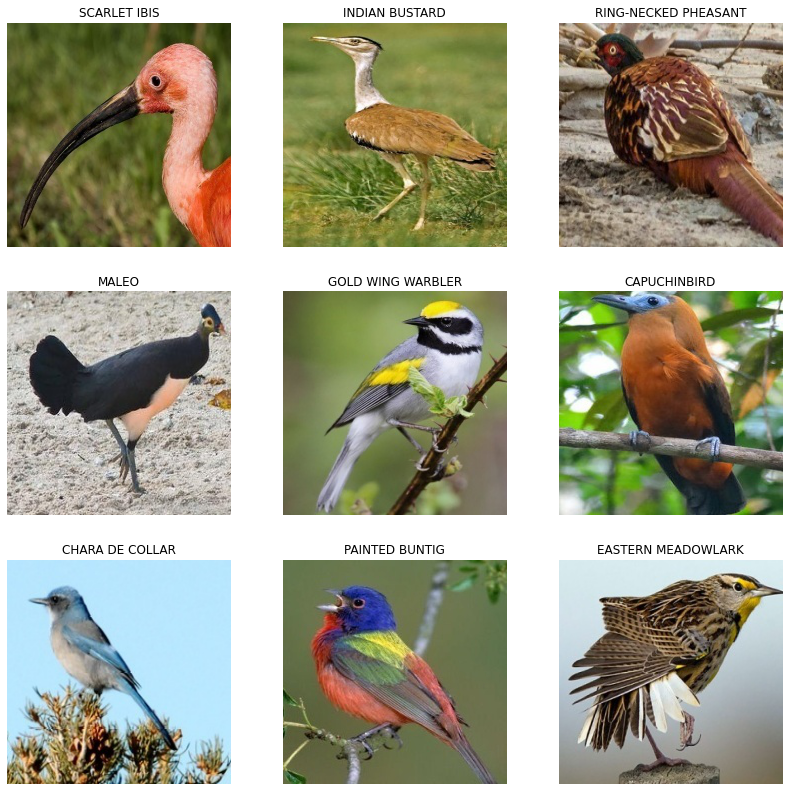

In [9]:
num_classes=len(os.listdir('/root/train'))
fig, ax= plt.subplots(nrows=3, ncols=3, figsize=(14,14))
for i in range(3):
  for j in range(3):
    bird_species=os.listdir('/root/train')[random.randint(0,num_classes-1)]  # selecting a random dir of birds in the range of 0-9
    bird_dir=os.path.join('/root/train/'+bird_species)
    img_path=random.choice(os.listdir(bird_dir))
    rand_img=mpimg.imread(os.path.join(bird_dir+'/'+img_path))
    print(rand_img.shape)
    ax[i, j].imshow(rand_img)
    ax[i, j].set_title(bird_species)
    ax[i, j].axis('off')
    

  

# with image data generators

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1/255, horizontal_flip=True, shear_range=0.5, rotation_range=45,zoom_range=0.3)
test_datagen=ImageDataGenerator(rescale=1/255)

In [ ]:
tot=0
for bird_species in os.listdir('/root/train/'):
  tot+=len(os.listdir(os.path.join('/root/train/'+ bird_species)))
print(f'Total training pics:-> {tot}')
tot=0
for bird_species in os.listdir('/root/test/'):
  tot+=len(os.listdir(os.path.join('/root/test/'+ bird_species)))
print(f'Total testing pics:-> {tot}')
tot=0
for bird_species in os.listdir('/root/valid/'):
  tot+=len(os.listdir(os.path.join('/root/valid/'+ bird_species)))
print(f'Total validation pics:-> {tot}')

Total training pics:-> 35215
Total testing pics:-> 1250
Total validation pics:-> 1250


In [ ]:
train_generator=train_datagen.flow_from_directory('/root/train', target_size=(224,224), class_mode='categorical',batch_size=128, shuffle=True, seed=43)
test_generator=test_datagen.flow_from_directory('/root/test/', target_size=(224,224), class_mode='categorical' )

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


# Now time to tune the hyperparameters(benchmark/Naive model)...

In [ ]:
import numpy as np
np.geomspace(10e-1, 10e-5,5) # an example

array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04])

In [ ]:
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
def create_model(hp):
  model=keras.Sequential()
  model.add(keras.layers.Conv2D(filters=hp.Int('filter1', min_value=16, max_value=64, step=16), kernel_size=hp.Choice('kernel',values=[3,5]), input_shape=(224,224,3), padding='same', activation='relu'))
  model.add(keras.layers.Conv2D(filters=hp.Int('filter2', min_value=16, max_value=64, step=16), kernel_size=(3,3), activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPooling2D(hp.Choice('size', [2,3])))
  model.add(keras.layers.Conv2D(filters=hp.Int('filter3', min_value=16, max_value=64, step=16), kernel_size=(3,3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
  model.add(keras.layers.Conv2D(filters=hp.Int('filter3', min_value=16, max_value=64, step=16), kernel_size=(3,3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPooling2D(hp.Choice('size2', [2,3])))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1024, activation=hp.Choice('activation1', values=['relu','tanh'])))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(250, activation='softmax'))
  model.compile(optimizer=keras.optimizers.Adam(lr=hp.Choice('lr', list(np.geomspace(10e-1,10e-4,4))[1:])), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
tuner=kerastuner.tuners.RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=5,
    # executions_per_trial=2,
    directory='/content/drive/MyDrive/Kaggle/',
    project_name='Birds_classifier'
)
tuner.search(train_generator, epochs=3, validation_data=test_generator)
# tuner.search(data, labels, epochs=3, validation_data=(valid_data,valid_labels))

Trial 4 Complete [00h 20m 09s]
val_accuracy: 0.2240000069141388

Best val_accuracy So Far: 0.2240000069141388
Total elapsed time: 01h 23m 33s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# best_model=tuner.get_best_models(num_models=1)[0]
best_hp=tuner.get_best_hyperparameters()[0]
model1 = tuner.hypermodel.build(best_hp)
# best_model.summary()

In [ ]:
model1.fit(train_generator, epochs=20,validation_data=test_generator, verbose=1)

In [ ]:
# !mkdir /content/drive/MyDrive/Kaggle/Birds_classifier
model1.save('/content/drive/MyDrive/Kaggle/Birds_classifier/BirdsModel')  # in h5 format and can be loaded back by using models.load_model(path)

# ResNet architecture and its tuning

In [10]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1/255, horizontal_flip=True, shear_range=0.5, rotation_range=45,zoom_range=0.3)
test_datagen=ImageDataGenerator(rescale=1/255)
train_generator=train_datagen.flow_from_directory('/root/train', target_size=(224,224), class_mode='categorical', shuffle=True, seed=43)
test_generator=test_datagen.flow_from_directory('/root/test/', target_size=(224,224), class_mode='categorical' )

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [11]:
from kerastuner.tuners import Hyperband
from kerastuner.applications import HyperResNet

In [12]:
model=HyperResNet(input_shape=(224,224,3), classes=250)
tuner=Hyperband(model, 
              objective='val_accuracy',
              max_epochs=3,
              seed=3,
              directory='/content/drive/MyDrive/Kaggle/',
              project_name='ResNet_for_birds')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Kaggle/ResNet_for_birds/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Kaggle/ResNet_for_birds/tuner0.json


In [13]:
tuner.search(train_generator,validation_data=test_generator)
best_model=tuner.get_best_models(num_models=1)[0]

INFO:tensorflow:Oracle triggered exit


In [21]:
# best_model=keras.models.load_model('/content/drive/MyDrive/Kaggle/ResNet_for_birds/')
best_model.fit(train_generator,validation_data=test_generator, epochs=140, initial_epoch=140)

In [ ]:
from keras.utils import plot_model
plot_model(best_model, to_file='/content/drive/MyDrive/Kaggle/ResNet_for_birds/resnet_diagram.png',show_shapes=True)

In [15]:
best_model.save('/content/drive/MyDrive/Kaggle/ResNet_for_birds/resnet_model.h5')
best_model.save('/content/drive/MyDrive/Kaggle/ResNet_for_birds/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Kaggle/ResNet_for_birds/assets


In [16]:
converter=tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model= converter.convert()

# save the model
# tflite_model_file=pathlib.Path('path/to/save/model')
# tflite_model_file.write_bytes(tflite_model)
  # or
open('/content/drive/MyDrive/Kaggle/ResNet_for_birds/resnet-model.tflite' , 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpkmidsmjs/assets


171924256

In [16]:
best_model.fit(train_generator,validation_data=test_generator, epochs=110, initial_epoch=100)

Epoch 101/110
1101/1101 [==============================] - 660s 599ms/step - loss: 0.2694 - accuracy: 0.9339 - val_loss: 26.3605 - val_accuracy: 0.8848
Epoch 102/110
1101/1101 [==============================] - 665s 603ms/step - loss: 0.2719 - accuracy: 0.9335 - val_loss: 26.3542 - val_accuracy: 0.9000
Epoch 103/110
1101/1101 [==============================] - 665s 603ms/step - loss: 0.3022 - accuracy: 0.9344 - val_loss: 12.6468 - val_accuracy: 0.9088
Epoch 104/110
1101/1101 [==============================] - 664s 602ms/step - loss: 0.2708 - accuracy: 0.9346 - val_loss: 3.8739 - val_accuracy: 0.9192
Epoch 105/110
1101/1101 [==============================] - 663s 602ms/step - loss: 0.3069 - accuracy: 0.9343 - val_loss: 56.0260 - val_accuracy: 0.8680
Epoch 106/110
1101/1101 [==============================] - 664s 603ms/step - loss: 0.2497 - accuracy: 0.9401 - val_loss: 24.5142 - val_accuracy: 0.9088
Epoch 107/110
1101/1101 [==============================] - 664s 603ms/step - loss: 0.2721

In [17]:
best_model.save('/content/drive/MyDrive/Kaggle/ResNet_for_birds/resnet_model.h5')
best_model.save('/content/drive/MyDrive/Kaggle/ResNet_for_birds/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Kaggle/ResNet_for_birds/assets


*Here we go with the Tensorflow lite architecture for further understanding for deploying the model on the mobile*


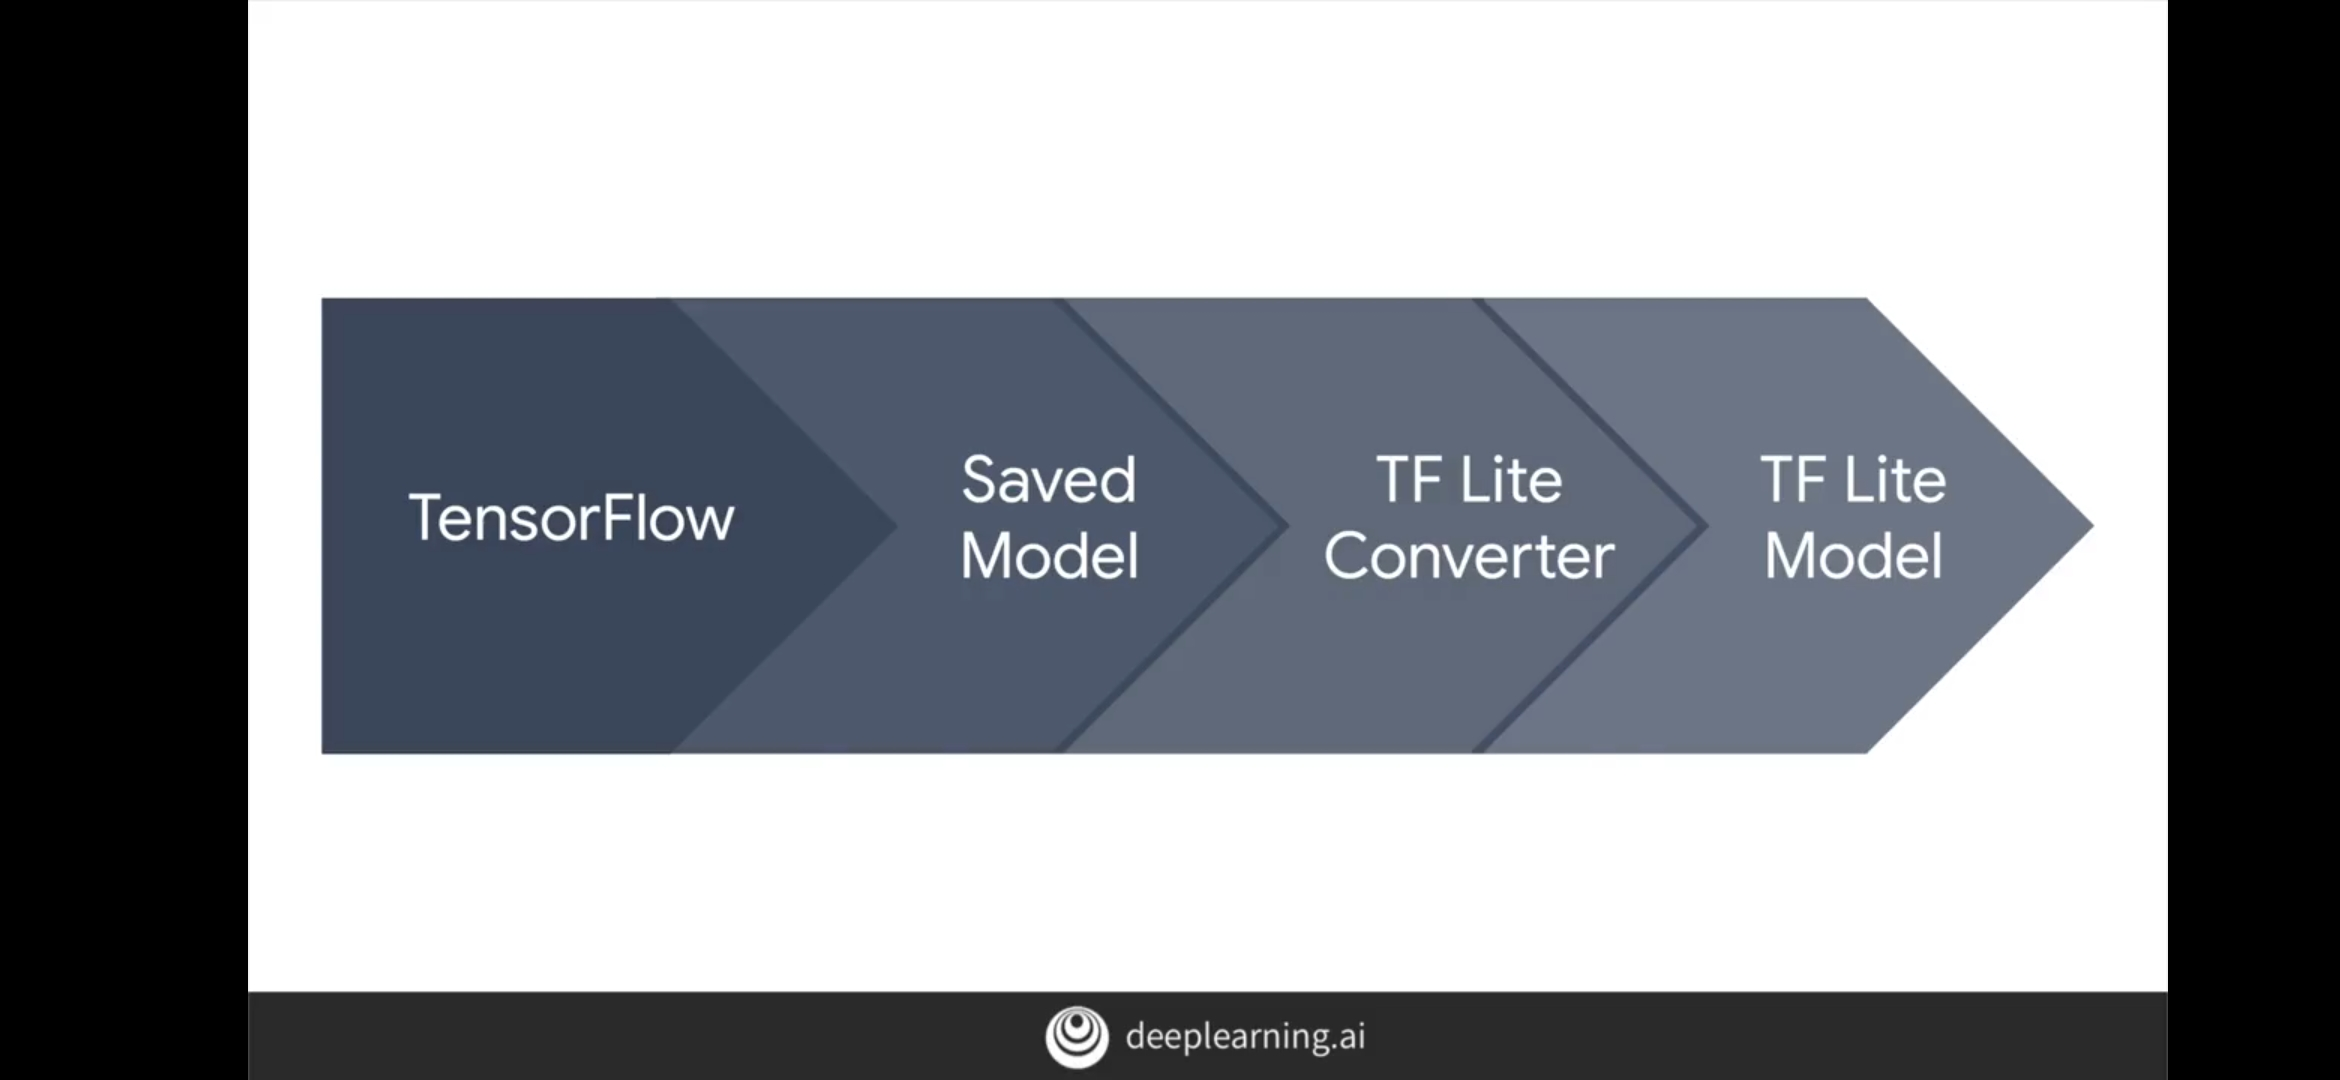

**Pic credits: deeplearning.ai**

In [ ]:
model=keras.models.load_model('/content/drive/MyDrive/Kaggle/Birds_classifier/BirdsModel')
# for TFLite mobile version conversion procedure
# with keras save func
'''
   model.save('modelname.h5')
   # convert the model
      converter=tf.lite.TFLiteConverter.from_keras_model(model)
      tflite_model= converter.convert()

   # save the model
      tflite_model_file=pathlib.Path('path/to/save/model')
      tflite_model_file.write_bytes(tflite_model)

'''


# with tf saved_model
'''
   (import pathlib) first
   # export the savemodel
      export_dir='path/to/location'
      tf.saved_model.save(model1,export_dir)
   # convert the model
      converter=tf.lite.TFLiteConverter.from_saved_model(export_dir)
      tflite_model= converter.convert()
   # save the model
      tflite_model_file=pathlib.Path('path/to/save/model')
      tflite_model_file.write_bytes(tflite_model)

  That's it :)
'''

***Quantization is a technique which reduces the precision and model size to work better on mobile***

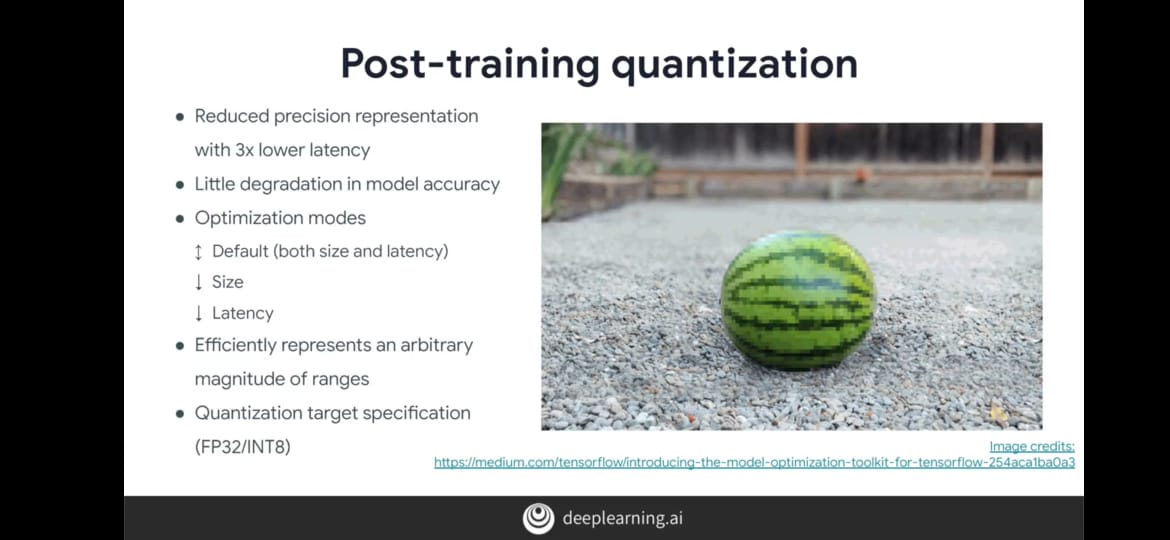